<a href="https://colab.research.google.com/github/AkshayaKorrapati/AkshayaKorrapati/blob/main/Deepfake%20detection%20using%20faceforensics%2B%2B%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
xdxd003_ff_c23_path = kagglehub.dataset_download('xdxd003/ff-c23')

print('Data source import complete.')


Data source import complete.


Using device: cpu
[INFO] Total videos found: 6000
[INFO] Real: 1000 | Fake: 5000
[INFO] Initializing model...
[INFO] Total parameters: 4,682,302
[INFO] Starting training...
Epoch 1/1, Batch 0/1920, Loss: 0.6129
Epoch 1/1, Batch 10/1920, Loss: 0.7403
Epoch 1/1, Batch 20/1920, Loss: 0.6043
Epoch 1/1, Batch 30/1920, Loss: 0.5220
Epoch 1/1, Batch 40/1920, Loss: 0.5521
Epoch 1/1, Batch 50/1920, Loss: 0.5290
Epoch 1/1, Batch 60/1920, Loss: 0.6665
Epoch 1/1, Batch 70/1920, Loss: 0.7153
Epoch 1/1, Batch 80/1920, Loss: 0.5815
Epoch 1/1, Batch 90/1920, Loss: 0.6182
Epoch 1/1, Batch 100/1920, Loss: 0.5624
Epoch 1/1, Batch 110/1920, Loss: 0.4124
Epoch 1/1, Batch 120/1920, Loss: 0.5867
Epoch 1/1, Batch 130/1920, Loss: 0.6062
Epoch 1/1, Batch 140/1920, Loss: 0.5483
Epoch 1/1, Batch 150/1920, Loss: 0.6674
Epoch 1/1, Batch 160/1920, Loss: 0.6395
Epoch 1/1, Batch 170/1920, Loss: 0.5954
Epoch 1/1, Batch 180/1920, Loss: 0.7095
Epoch 1/1, Batch 190/1920, Loss: 0.6362
Epoch 1/1, Batch 200/1920, Loss: 0.487

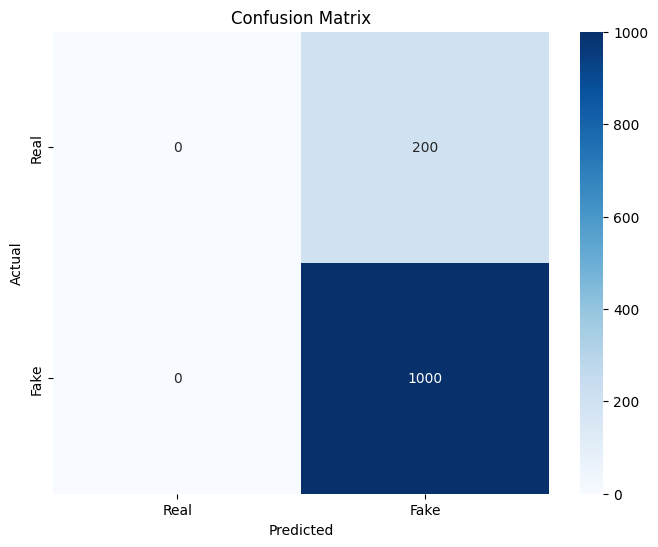

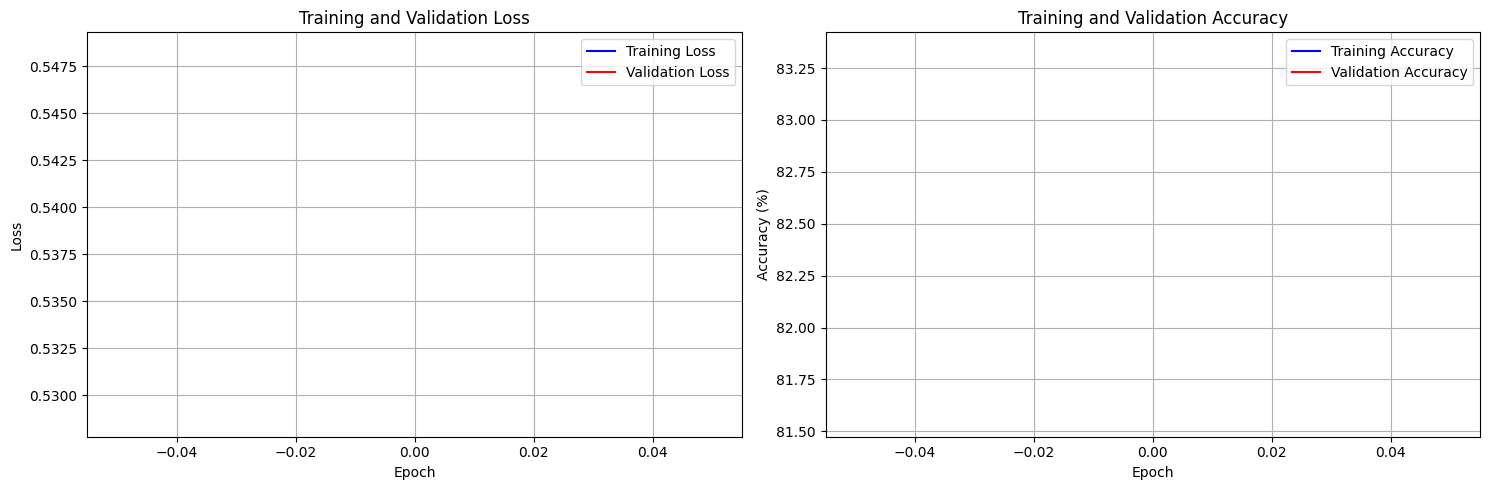

In [ ]:
# ---- imports ----
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---- Dataset Class ----
class FaceForensicsDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None, frames_per_video=16, img_size=224):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.frames_per_video = frames_per_video
        self.img_size = img_size

    def __len__(self):
        return len(self.video_paths)

    def extract_frames(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            dummy = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            return [dummy] * self.frames_per_video

        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total == 0:
            cap.release()
            dummy = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            return [dummy] * self.frames_per_video

        idxs = np.linspace(0, total - 1, self.frames_per_video, dtype=int)
        for idx in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (self.img_size, self.img_size))
                frames.append(frame)
            else:
                frames.append(frames[-1] if frames else np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8))

        cap.release()
        while len(frames) < self.frames_per_video:
            frames.append(frames[-1] if frames else np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8))
        return frames[:self.frames_per_video]

    def __getitem__(self, idx):
        video = self.extract_frames(self.video_paths[idx])
        label = self.labels[idx]
        if self.transform:
            video = [self.transform(frame) for frame in video]
        else:
            video = [torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0 for frame in video]
        return torch.stack(video), torch.tensor(label, dtype=torch.long)

class MBConvBlock(nn.Module):
    """Mobile Inverted Bottleneck Convolution Block"""

    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio=0.25):
        super(MBConvBlock, self).__init__()

        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)

        # Expansion phase
        hidden_dim = in_channels * expand_ratio
        self.expand_conv = nn.Conv2d(in_channels, hidden_dim, 1, bias=False) if expand_ratio != 1 else None
        self.bn1 = nn.BatchNorm2d(hidden_dim) if expand_ratio != 1 else None

        # Depthwise convolution
        self.depthwise_conv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride,
                                       kernel_size//2, groups=hidden_dim, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_dim)

        # Squeeze and Excitation
        se_dim = int(in_channels * se_ratio)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(hidden_dim, se_dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(se_dim, hidden_dim, 1),
            nn.Sigmoid()
        )

        # Pointwise convolution
        self.pointwise_conv = nn.Conv2d(hidden_dim, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.swish = nn.SiLU()

    def forward(self, x):
        identity = x

        # Expansion
        if self.expand_conv is not None:
            x = self.swish(self.bn1(self.expand_conv(x)))

        # Depthwise
        x = self.swish(self.bn2(self.depthwise_conv(x)))

        # Squeeze and Excitation
        se_out = self.se(x)
        x = x * se_out

        # Pointwise
        x = self.bn3(self.pointwise_conv(x))

        # Residual connection
        if self.use_residual:
            x = x + identity

        return x

class EnhancedEfficientNetB0(nn.Module):
    """Enhanced EfficientNet B0 for spatial feature extraction"""

    def __init__(self, num_classes=2):
        super(EnhancedEfficientNetB0, self).__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        # MBConv blocks configuration for EfficientNet-B0
        # (in_channels, out_channels, kernel_size, stride, expand_ratio, num_layers)
        mb_config = [
            (32, 16, 3, 1, 1, 1),
            (16, 24, 3, 2, 6, 2),
            (24, 40, 5, 2, 6, 2),
            (40, 80, 3, 2, 6, 3),
            (80, 112, 5, 1, 6, 3),
            (112, 192, 5, 2, 6, 4),
            (192, 320, 3, 1, 6, 1),
        ]

        # Build MBConv blocks
        self.blocks = nn.ModuleList()
        for in_ch, out_ch, k, s, exp, num_layers in mb_config:
            for i in range(num_layers):
                stride = s if i == 0 else 1
                input_ch = in_ch if i == 0 else out_ch
                self.blocks.append(MBConvBlock(input_ch, out_ch, k, stride, exp))

        # Head
        self.head_conv = nn.Sequential(
            nn.Conv2d(320, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU()
        )

        # Feature Pyramid Network components
        self.fpn_conv1 = nn.Conv2d(40, 256, 1)  # From block 2
        self.fpn_conv2 = nn.Conv2d(112, 256, 1)  # From block 4
        self.fpn_conv3 = nn.Conv2d(320, 256, 1)  # From block 6

        self.fpn_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Global Average Pooling and final classification
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, 512)  # Feature vector for temporal analysis

    def forward(self, x):
        # Stem
        x = self.stem(x)

        # MBConv blocks with FPN feature extraction
        fpn_features = []

        for i, block in enumerate(self.blocks):
            x = block(x)

            # Collect features for FPN at specific blocks
            if i == 3:  # After block 2 (40 channels)
                fpn_features.append(self.fpn_conv1(x))
            elif i == 9:  # After block 4 (112 channels)
                fpn_features.append(self.fpn_conv2(x))

        # Final feature for FPN
        fpn_features.append(self.fpn_conv3(x))

        # Feature Pyramid Network fusion
        # Start from top feature
        fpn_out = fpn_features[2]  # Top level (320 -> 256)

        # Fuse with middle level
        fpn_out = self.fpn_upsample(fpn_out) + fpn_features[1]

        # Fuse with bottom level
        fpn_out = self.fpn_upsample(fpn_out)
        if fpn_out.size()[2:] != fpn_features[0].size()[2:]:
            fpn_out = F.interpolate(fpn_out, size=fpn_features[0].size()[2:], mode='bilinear', align_corners=False)
        fpn_out = fpn_out + fpn_features[0]

        # Global average pooling
        fpn_out = self.global_avg_pool(fpn_out)
        fpn_out = fpn_out.view(fpn_out.size(0), -1)

        # Feature extraction for temporal analysis
        features = self.dropout(fpn_out)
        features = self.fc(features)

        return features

class TemporalConvNet(nn.Module):
    """Fixed Temporal Convolutional Network for sequential analysis"""

    def __init__(self, input_dim, hidden_dim=128, num_levels=3, kernel_size=3):
        super(TemporalConvNet, self).__init__()

        self.num_levels = num_levels
        self.hidden_dim = hidden_dim

        # Input projection
        self.input_projection = nn.Conv1d(input_dim, hidden_dim, 1)

        # TCN layers with causal padding to maintain sequence length
        self.tcn_layers = nn.ModuleList()

        for i in range(num_levels):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation

            # Main TCN block with causal padding
            tcn_block = nn.Sequential(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size,
                         padding=padding, dilation=dilation),
                nn.BatchNorm1d(hidden_dim * 2),
                nn.GLU(dim=1),  # Gated Linear Unit reduces channels by half
                nn.Dropout(0.1),
                nn.Conv1d(hidden_dim, hidden_dim, 1),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            )

            self.tcn_layers.append(tcn_block)

        # Final classification layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, feature_dim)
        # Convert to (batch_size, feature_dim, sequence_length) for Conv1D
        x = x.transpose(1, 2)

        # Input projection to match hidden dimensions
        x = self.input_projection(x)

        # Pass through TCN layers with residual connections
        for tcn_layer in self.tcn_layers:
            residual = x

            # Apply TCN block
            out = tcn_layer(x)

            # Ensure same sequence length for residual connection
            if out.size(-1) > residual.size(-1):
                # Trim the output to match residual size (causal padding)
                out = out[:, :, :residual.size(-1)]
            elif out.size(-1) < residual.size(-1):
                # This shouldn't happen with proper padding, but just in case
                residual = residual[:, :, :out.size(-1)]

            # Residual connection
            x = out + residual

        # Global pooling and classification
        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.classifier(x)

        return x

class HybridDeepfakeDetector(nn.Module):
    """Complete hybrid framework combining EfficientNet and TCN"""

    def __init__(self, num_classes=2):
        super(HybridDeepfakeDetector, self).__init__()

        self.spatial_extractor = EnhancedEfficientNetB0(num_classes)
        self.temporal_analyzer = TemporalConvNet(input_dim=512, hidden_dim=128)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, channels, height, width)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape for spatial processing
        x = x.view(-1, x.size(2), x.size(3), x.size(4))

        # Extract spatial features
        spatial_features = self.spatial_extractor(x)

        # Reshape back to sequence format
        spatial_features = spatial_features.view(batch_size, seq_len, -1)

        # Temporal analysis
        output = self.temporal_analyzer(spatial_features)

        return output

def get_transforms():
    train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train, val

# ---- Data Loader ----
def load_faceforensics_data(data_path):
    """Updated loader matching your folder structure."""
    video_paths, labels = [], []

    # Real videos
    real_path = os.path.join(data_path, 'original')
    if os.path.exists(real_path):
        for file in os.listdir(real_path):
            if file.endswith('.mp4'):
                video_paths.append(os.path.join(real_path, file))
                labels.append(0)

    # Fake videos
    fake_dirs = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']
    for fake_dir in fake_dirs:
        fake_path = os.path.join(data_path, fake_dir)
        if os.path.exists(fake_path):
            for file in os.listdir(fake_path):
                if file.endswith('.mp4'):
                    video_paths.append(os.path.join(fake_path, file))
                    labels.append(1)

    print(f"[INFO] Total videos found: {len(video_paths)}")
    print(f"[INFO] Real: {labels.count(0)} | Fake: {labels.count(1)}")
    return video_paths, labels

def train_model(model, train_loader, val_loader, num_epochs=40, learning_rate=1e-6):
    """Train the deepfake detection model"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * correct_val / total_val

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_deepfake_detector.pth')

        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model and generate confusion matrix"""

    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)

    # Generate classification report
    class_names = ['Real', 'Fake']
    report = classification_report(all_targets, all_predictions,
                                 target_names=class_names, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)

    return accuracy, report, cm, all_predictions, all_targets

def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training metrics"""

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names=['Real', 'Fake']):
    """Plot confusion matrix"""

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def main():
    DATA_PATH = '/kaggle/input/ff-c23/FaceForensics++_C23'
    BATCH_SIZE = 2
    EPOCHS = 1
    LR = 1e-6
    FRAMES = 8

    video_paths, labels = load_faceforensics_data(DATA_PATH)
    if len(video_paths) == 0:
        raise RuntimeError("No video files found. Please check the dataset path or structure.")

    train_paths, test_paths, train_labels, test_labels = train_test_split(
        video_paths, labels, test_size=0.2, stratify=labels, random_state=42)

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

    train_t, val_t = get_transforms()
    train_ds = FaceForensicsDataset(train_paths, train_labels, train_t, FRAMES)
    val_ds   = FaceForensicsDataset(val_paths, val_labels, val_t, FRAMES)
    test_ds  = FaceForensicsDataset(test_paths, test_labels, val_t, FRAMES)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print("[INFO] Initializing model...")
    model = HybridDeepfakeDetector(num_classes=2).to(device)
    print(f"[INFO] Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("[INFO] Starting training...")
    train_losses, val_losses, train_acc, val_acc = train_model(model, train_dl, val_dl, EPOCHS, LR)

    model.load_state_dict(torch.load('best_deepfake_detector.pth'))
    acc, report, cm, preds, targs = evaluate_model(model, test_dl)

    print(f"\n[RESULT] Test Accuracy: {acc:.4f}")
    print(classification_report(targs, preds, target_names=['Real', 'Fake']))
    plot_confusion_matrix(cm)
    plot_training_metrics(train_losses, val_losses, train_acc, val_acc)

    return model, acc

if __name__ == "__main__":
    model, acc = main()